In [1]:
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import classification_report

In [5]:
path_to_train='Train/'
path_to_valid = 'Valid/'
path_to_test='Test/'

In [6]:
path_to_entropy='Entropy/'

In [7]:
X_train=np.load(path_to_train+"X_train.npy")
X_valid=np.load(path_to_valid+"X_valid.npy")

In [8]:
y_train_superclass=np.load(path_to_train+"y_train_subclass.npy")
y_valid_superclass=np.load(path_to_valid+"y_valid_subclass.npy")

In [9]:
X_test=np.load(path_to_test+"X_test.npy")
y_test=np.load(path_to_test+"y_test_subclass.npy")

In [10]:
X_entropy = np.load(path_to_entropy+"X_entropy_file.npy")

In [11]:
X_train.shape[0], X_valid.shape[0], X_test.shape[0]

(12069, 2587, 2586)

In [12]:
X_train_idx = np.array([range(X_train.shape[0])])

In [13]:
X_valid_idx = np.array([range(X_train.shape[0], X_train.shape[0]+X_valid.shape[0])])

In [14]:
X_test_idx = np.array([range(X_train.shape[0]+X_valid.shape[0], X_train.shape[0]+X_valid.shape[0]+X_test.shape[0])])

In [15]:
X_train_idx = np.squeeze(X_train_idx)

In [16]:
X_valid_idx = np.squeeze(X_valid_idx)

In [17]:
X_test_idx = np.squeeze(X_test_idx)

In [18]:
batch_size = 128

In [19]:
X_train_tensor = torch.Tensor(X_train_idx)
y_train_tensor = torch.LongTensor(y_train_superclass)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

X_valid_tensor = torch.Tensor(X_valid_idx)
y_valid_tensor = torch.LongTensor(y_valid_superclass)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)

In [20]:
X_array = np.concatenate((X_train, X_valid, X_test))    

In [21]:
del X_train
del X_valid
del X_test

In [22]:
del y_train_superclass
del y_valid_superclass

del X_train_tensor
del y_train_tensor

del X_valid_tensor
del y_valid_tensor

In [23]:
def train(epoch,my_model, data_loader, optimizer, loss_function):
    losses=[]
    my_model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        output = my_model(X_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X_batch), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
        losses.append(loss.data.numpy())
    return np.mean(losses)

In [24]:
def test(my_model, data_loader, loss_function):
    accuracy_arr = []
    my_model.eval()
    test_loss = 0
    correct = 0
    for X_batch, y_batch in data_loader:
        output = my_model(X_batch)
        test_loss += loss_function(output, y_batch).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y_batch.data.view_as(pred)).cpu().sum()

    test_loss /= len(data_loader)
    acc = correct / len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return acc,test_loss

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score

def print_confusion_matrix(model, X, y):
    model.eval()
    y_pred = model(torch.Tensor(X)).data.numpy().argmax(axis = 1)
    print(confusion_matrix(y, y_pred))
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy = {accuracy}")
    return accuracy

In [26]:
def training(number_of_epoches, model, optimizer, loss_function, learning_rate, train_loader, valid_loader):
    loss_train=[]
    loss_valid=[]
    acc=[]
    best_accuracy, last_accuracy = 0, 0
    patience = 3
    trigger_times = 0 
    
    for epoch in range(number_of_epoches):
        loss_train.append(train(epoch + 1,model, train_loader, optimizer, loss_function))
        accuracy, current_loss = test(model, valid_loader, loss_function)
        acc.append(accuracy)
        loss_valid.append(current_loss)
        if accuracy < last_accuracy:
            trigger_times += 1
            if trigger_times > patience:
                break
        else:
            trigger_times = 0  
        if epoch ==int(number_of_epoches * 0.3):
            optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)    
        print("Trigger times", trigger_times) 
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        last_accuracy = accuracy
        
    return loss_train, loss_valid, acc

In [27]:
loss_function=nn.CrossEntropyLoss()

In [28]:
learning_rate = 0.001
learning_rate_2 = 0.0001

In [29]:
input_shape=1000

In [30]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1):
        super().__init__()

        self.model = nn.Sequential(
        nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size[0], padding = kernel_size[0] //2, stride = stride),
        nn.BatchNorm1d(64), nn.LeakyReLU(0.01),
        nn.Conv1d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size[1], padding = kernel_size[1] // 2), nn.BatchNorm1d(64)
        )
        self.leakyReLU = nn.LeakyReLU(0.01)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size = 1, stride = stride)
            )
        self.bn = nn.BatchNorm1d(out_channels)

        
    def forward(self, X):
        output = self.model(X)
        output += self.shortcut(X)
        output = self.leakyReLU(output)

        return output

In [31]:
class CNN_entropy_ResNet(nn.Module):
    def __init__(self,in_channels,  input_shape, n_outputs, block, kernel_size = [3,3,3,5,5]):
        super().__init__()

        self.conv1D_1 = nn.Conv1d(in_channels = in_channels, out_channels = 64, kernel_size = kernel_size[0], padding = 2)
        self.leakyReLU_1 = nn.LeakyReLU(0.01)
    
        self.block1 = self.make_layer(block, 64, 64, kernel_size[1:3], 2)
        self.block2 = self.make_layer(block, 64, 64, kernel_size[3:], 2)
        
        self.adAvgPooling = nn.AdaptiveAvgPool1d(2)
        self.adAvgPooling2 = nn.AdaptiveAvgPool1d(2)
        self.flatten = nn.Flatten()
        self.flatten2 = nn.Flatten()
        self.fc = nn.Linear(2 * 64 + 108, n_outputs)
        self.bn = nn.BatchNorm1d(n_outputs) 
        self.drop1 = nn.Dropout(0.6)
        self.leakyReLU_6 = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(128,128)
        self.drop2 = nn.Dropout(0.2)
        self.leakyReLU_7 = nn.LeakyReLU(0.01)
        self.fc3 = nn.Linear(128,n_outputs)
        self.softmax = nn.Softmax(dim=1)
        self.maxpool = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool1d(2)
        self.maxpool3 = nn.MaxPool1d(2)
        self.bn_1 = nn.BatchNorm1d(64)

    def make_layer(self, block, in_channels, out_channels, kernel_size, stride = 1):               

        return nn.Sequential(block(in_channels, out_channels, kernel_size, stride))

    def forward(self, x):
        X_arr = []
        X_entr = []
        for el in np.array(x):
            X_arr.append(X_array[int(el)])
            X_entr.append(X_entropy[int(el)])
        
        x = torch.Tensor(np.array(X_arr))
        X_entr = torch.Tensor(np.array(X_entr))
        del X_arr
        output = self.conv1D_1(x)
        output = self.bn_1(output)
        output = self.leakyReLU_1(output)
        #output = self.maxpool(output)

        output = self.block1(output)
        #output = self.adAvgPooling2(output)
        #output = self.maxpool2(output)
        output = self.block2(output)      

        output = self.adAvgPooling(output)
        output = self.flatten(output)
        X_entr = self.flatten2(X_entr)
        output = torch.cat((X_entr, output), axis = 1)
        output = self.fc(output)
        output = self.bn(output)
        #output = self.drop1(output)
        #output = self.leakyReLU_6(output)
        #output = self.fc2(output)
        #output = self.drop2(output)
        #output = self.leakyReLU_7(output)
        #output = self.fc3(output)
        output = self.softmax(output)
        return output

In [32]:
model = CNN_entropy_ResNet(12, 1000, 20, BasicBlock, [5,5,5,5,5])

In [33]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [34]:
loss_train, loss_valid, accuracy = training(30, model, optimizer, loss_function, learning_rate_2, train_loader, valid_loader)

Train Epoch: 1 [0/12069 (0%)]	Loss: 2.996621
Train Epoch: 1 [1280/12069 (11%)]	Loss: 2.964686
Train Epoch: 1 [2560/12069 (21%)]	Loss: 2.903444
Train Epoch: 1 [3840/12069 (32%)]	Loss: 2.883008
Train Epoch: 1 [5120/12069 (42%)]	Loss: 2.860134
Train Epoch: 1 [6400/12069 (53%)]	Loss: 2.851246
Train Epoch: 1 [7680/12069 (63%)]	Loss: 2.849360
Train Epoch: 1 [8960/12069 (74%)]	Loss: 2.818808
Train Epoch: 1 [10240/12069 (84%)]	Loss: 2.842999
Train Epoch: 1 [11520/12069 (95%)]	Loss: 2.799016

Test set: Average loss: 2.8089, Accuracy: 1261/2587 (48.74%)

Trigger times 0
Train Epoch: 2 [0/12069 (0%)]	Loss: 2.774973
Train Epoch: 2 [1280/12069 (11%)]	Loss: 2.792642
Train Epoch: 2 [2560/12069 (21%)]	Loss: 2.790979
Train Epoch: 2 [3840/12069 (32%)]	Loss: 2.737852
Train Epoch: 2 [5120/12069 (42%)]	Loss: 2.774753
Train Epoch: 2 [6400/12069 (53%)]	Loss: 2.764746
Train Epoch: 2 [7680/12069 (63%)]	Loss: 2.773834
Train Epoch: 2 [8960/12069 (74%)]	Loss: 2.750973
Train Epoch: 2 [10240/12069 (84%)]	Loss: 2.74

Train Epoch: 15 [6400/12069 (53%)]	Loss: 2.424915
Train Epoch: 15 [7680/12069 (63%)]	Loss: 2.415610
Train Epoch: 15 [8960/12069 (74%)]	Loss: 2.362379
Train Epoch: 15 [10240/12069 (84%)]	Loss: 2.472028
Train Epoch: 15 [11520/12069 (95%)]	Loss: 2.480434

Test set: Average loss: 2.4354, Accuracy: 1859/2587 (71.86%)

Trigger times 0
Train Epoch: 16 [0/12069 (0%)]	Loss: 2.375502
Train Epoch: 16 [1280/12069 (11%)]	Loss: 2.413253
Train Epoch: 16 [2560/12069 (21%)]	Loss: 2.402585
Train Epoch: 16 [3840/12069 (32%)]	Loss: 2.391195
Train Epoch: 16 [5120/12069 (42%)]	Loss: 2.415134
Train Epoch: 16 [6400/12069 (53%)]	Loss: 2.425647
Train Epoch: 16 [7680/12069 (63%)]	Loss: 2.319289
Train Epoch: 16 [8960/12069 (74%)]	Loss: 2.374861
Train Epoch: 16 [10240/12069 (84%)]	Loss: 2.436847
Train Epoch: 16 [11520/12069 (95%)]	Loss: 2.389140

Test set: Average loss: 2.4362, Accuracy: 1853/2587 (71.63%)

Trigger times 1
Train Epoch: 17 [0/12069 (0%)]	Loss: 2.416513
Train Epoch: 17 [1280/12069 (11%)]	Loss: 2.361

Train Epoch: 29 [10240/12069 (84%)]	Loss: 2.395461
Train Epoch: 29 [11520/12069 (95%)]	Loss: 2.357523

Test set: Average loss: 2.4334, Accuracy: 1861/2587 (71.94%)

Trigger times 1
Train Epoch: 30 [0/12069 (0%)]	Loss: 2.317246
Train Epoch: 30 [1280/12069 (11%)]	Loss: 2.375642
Train Epoch: 30 [2560/12069 (21%)]	Loss: 2.395439
Train Epoch: 30 [3840/12069 (32%)]	Loss: 2.403312
Train Epoch: 30 [5120/12069 (42%)]	Loss: 2.303926
Train Epoch: 30 [6400/12069 (53%)]	Loss: 2.295837
Train Epoch: 30 [7680/12069 (63%)]	Loss: 2.322775
Train Epoch: 30 [8960/12069 (74%)]	Loss: 2.401601
Train Epoch: 30 [10240/12069 (84%)]	Loss: 2.345631
Train Epoch: 30 [11520/12069 (95%)]	Loss: 2.321486

Test set: Average loss: 2.4185, Accuracy: 1868/2587 (72.21%)

Trigger times 0


In [35]:
print_confusion_matrix(model, X_test_idx, y_test)

[[ 43   0   0   0   0   0   0   1   0   0   0   3   0   0   0   1   0   0
    5   0]
 [  0   0   0   0   0  12   2   4  14   0   9   4   0   0   2   0   0   1
    1   0]
 [  0   0   0   0   0   0   1   4   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   4   0   0   0   1   0   0   0   3   0   0
    0   0]
 [  0   0   0   0   0   3  16   1   2   0  13   2   0   0   1   0   0   0
    1   0]
 [  0   0   0   0   0  33   0   7   5   0  11   4   0   0   4   0   0   2
    3   0]
 [  0   0   0   0   0   2 934   7   5   0  66   4   0   0   8   0   0   0
   22   0]
 [  8   0   0   0   0   9   9 190   9   0   4  16   0   0   6   2   0   0
    7   0]
 [  0   0   0   0   0   6   5   7  60   0  14   4   0   0   3   1   0   0
    1   0]
 [  0   0   0   0   0   7   1   2   5   0   6   3   0   0   0   0   0   1
    1   0]
 [  0   0   0   0   0  13  41   4   3   0 195   8   0   0   9   0   0   0
    4   0]
 [  4   0   0   0   0   4   9  13   1   0  14 130   0   0   9   0

0.7076566125290024

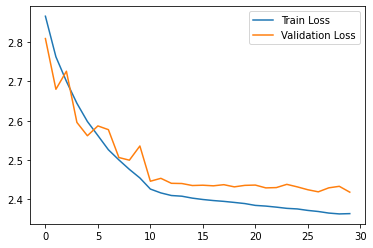

In [36]:
plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_valid, label = 'Validation Loss')
plt.legend()
plt.show()

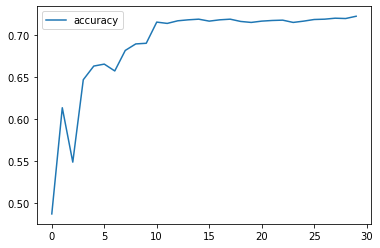

In [37]:
plt.plot(accuracy, label = 'accuracy')
plt.legend()
plt.show()

In [38]:
print("Best accuracy: ",np.max(accuracy)," Epoch: ", np.argmax(accuracy)+1)

Best accuracy:  0.7220719  Epoch:  30


In [39]:
model.eval()
y_pred = model(torch.Tensor(X_test_idx)).data.numpy().argmax(axis = 1)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.81      0.72        53
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        39
           5       0.34      0.48      0.40        69
           6       0.86      0.89      0.88      1048
           7       0.72      0.73      0.73       260
           8       0.54      0.59      0.57       101
           9       0.00      0.00      0.00        26
          10       0.50      0.70      0.59       277
          11       0.65      0.69      0.67       189
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00        50
          14       0.66      0.73      0.69       142
          15       0.88      0.92      0.90        74
          16       0.00      0.00      0.00         8
          17       0.33    

D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


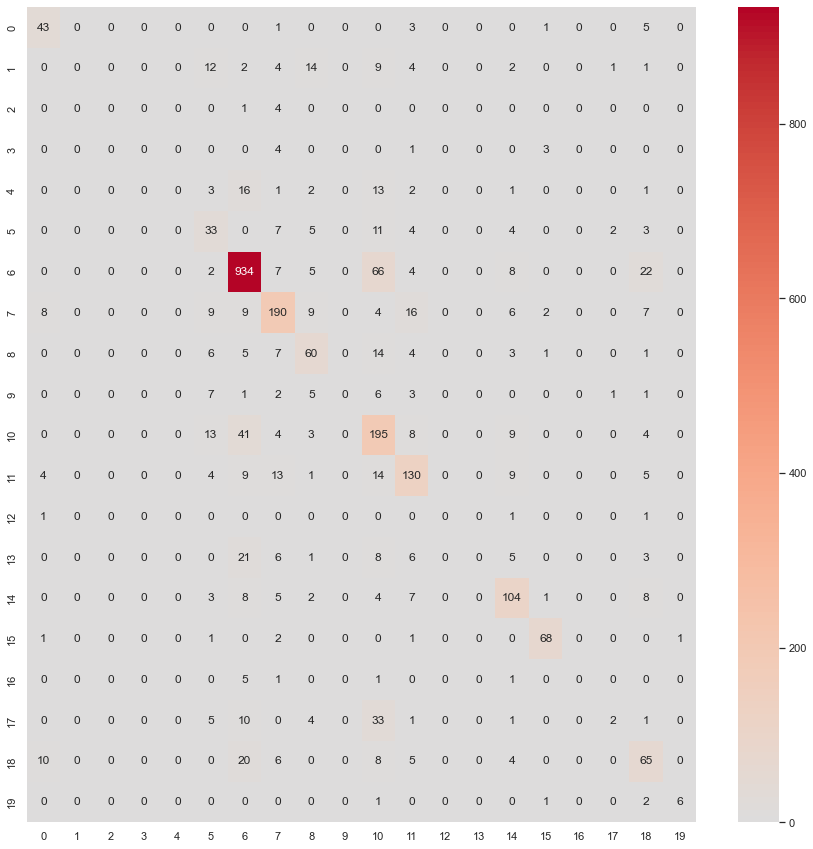

In [41]:
cm = confusion_matrix(y_test,y_pred)
sns.set(rc = {'figure.figsize':(15,15)})
f = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', center = 0)